In [18]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [48]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.289650,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.274967,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.267635,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.269468,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.274967,6445,ABEV3.SA


In [49]:

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]

# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)


# Parâmetros adicionais
t = 14
d = 10
e = 14
# Lista de parâmetros n para iterar
n_list = [14, 15]  # Exemplo de diferentes valores de n
alpha = 0.60  # Mantemos um único valor de alpha



price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Loop para calcular o RSI para cada valor em 'n_list'
for n in n_list:
    # Dias de alta e dias de baixa
    up_df, down_df = price_data[['Ticker', 'change_in_price']].copy(), price_data[['Ticker', 'change_in_price']].copy()

    # Salvando a diferença para dias de alta
    up_df.loc[up_df['change_in_price'] < 0, 'change_in_price'] = 0

    # Salvando a diferença para dias de baixa
    down_df.loc[down_df['change_in_price'] > 0, 'change_in_price'] = 0

    # Colocando as diferenças do dia de baixa em termos absolutos
    down_df['change_in_price'] = down_df['change_in_price'].abs()

    # Calculando o EWMA (Exponential Weighted Moving Average) para dias de alta e baixa
    ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())
    ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span=n).mean())

    # Calculando o Relative Strength (RS)
    relative_strength = ewma_up / ewma_down

    # Calculando o Relative Strength Index (RSI)
    relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

    # Salvando o RSI como uma nova coluna no dataframe
    price_data[f'RSI_{n}'] = relative_strength_index

    # Salvando colunas auxiliares para verificação (opcional)
    price_data[f'down_days_{n}'] = down_df['change_in_price']
    price_data[f'up_days_{n}'] = up_df['change_in_price']


# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)


# Criação das variáveis low_t e high_t
low_t, high_t = price_data[['Ticker', 'Low']].copy(), price_data[['Ticker', 'High']].copy()
# Cálculo dos valores mínimos e máximos baseados na janela t
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())

# Cálculo do k_percent
k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))


# Armazenando os resultados no DataFrame com nomes dinâmicos
price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent


# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)
price_data[f'r_percent_{t}'] = r_percent

# Price Rate of Change
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd



# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)


# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

price_data.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
11763,2025-01-02,54.709999,55.099998,54.230000,54.250000,54.250000,17623900,VALE3.SA,-0.299999,54.410308,-1.0,32.709994,0.299999,0.0,33.141092,0.299999,0.0,54.250000,-1.0,53.330002,59.939999,16.343516,-83.656484,-0.074368,-1.203018,-1.070986,365924838,52.669998
11764,2025-01-03,53.900002,54.000000,52.880001,53.240002,53.240002,23608700,VALE3.SA,-1.009998,53.708124,-1.0,25.572295,1.009998,0.0,26.456467,1.009998,0.0,53.240002,1.0,52.880001,59.590000,12.341626,-87.658374,-0.095438,-1.250832,-1.106955,342316138,54.490002
11765,2025-01-06,53.480000,53.790001,52.480000,52.560001,52.560001,21689500,VALE3.SA,-0.680000,53.019250,1.0,21.865682,0.680000,0.0,22.902074,0.680000,0.0,52.560001,1.0,52.480000,57.680000,10.370208,-89.629792,-0.102189,-1.328992,-1.151363,320626638,54.290001
11766,2025-01-07,52.630001,52.889999,51.939999,52.049999,52.049999,22070200,VALE3.SA,-0.510002,52.437700,1.0,19.428651,0.510002,0.0,20.537094,0.510002,0.0,52.049999,1.0,51.939999,56.709999,10.433984,-89.566016,-0.090374,-1.421474,-1.205385,298556438,54.020000
11767,2025-01-08,52.029999,52.290001,51.430000,51.549999,51.549999,24423800,VALE3.SA,-0.500000,51.905079,1.0,17.253360,0.500000,0.0,18.407321,0.500000,0.0,51.549999,1.0,51.430000,56.540001,9.297046,-90.702954,-0.082544,-1.520221,-1.268352,274132638,52.660000


In [50]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,RSI_14,down_days_14,up_days_14,RSI_15,down_days_15,up_days_15,Smoothed_Close_1,Verify,low_14,high_14,k_percent_14,r_percent_14,Price_Rate_Of_Change,MACD,MACD_EMA,On Balance Volume,Close_10
5733,2025-01-02,11.72,11.89,11.49,11.60,11.60,33417900,ABEV3.SA,-0.139999,11.717846,-1.0,17.590948,0.139999,0.00,18.939456,0.139999,0.00,11.60,-1.0,11.49,14.50,7.569641,-92.430359,-0.175025,-0.281425,-0.084130,-1473288787,11.08
5734,2025-01-03,11.49,11.55,11.27,11.33,11.33,41365900,ABEV3.SA,-0.270000,11.485138,-1.0,14.655374,0.270000,0.00,15.985276,0.270000,0.00,11.33,-1.0,11.27,14.36,6.962393,-93.037607,-0.193661,-0.340433,-0.135391,-1514654687,11.09
5735,2025-01-06,11.36,11.50,11.21,11.29,11.29,50881500,ABEV3.SA,-0.040000,11.368055,-1.0,14.248904,0.040000,0.00,15.573979,0.040000,0.00,11.29,-1.0,11.21,13.58,6.668999,-93.331001,-0.186684,-0.392125,-0.186738,-1565536187,11.05
5736,2025-01-07,11.30,11.58,11.27,11.54,11.54,34905200,ABEV3.SA,0.250000,11.471222,-1.0,28.541568,0.000000,0.25,28.681244,0.000000,0.25,11.54,-1.0,11.21,13.42,11.820003,-88.179997,-0.147182,-0.419925,-0.233375,-1530630987,11.25
5737,2025-01-08,11.48,11.53,11.28,11.42,11.42,39248800,ABEV3.SA,-0.120000,11.440489,-1.0,26.129481,0.120000,0.00,26.430271,0.120000,0.00,11.42,-1.0,11.21,13.42,10.429360,-89.570640,-0.135156,-0.439373,-0.274575,-1569879787,11.02


n: 14
Fold 1:
 - Correct Prediction (y_test): 49.69%
 - Correct Prediction (Verify): 50.00%
Fold 2:
 - Correct Prediction (y_test): 50.52%
 - Correct Prediction (Verify): 51.78%
Fold 3:
 - Correct Prediction (y_test): 53.04%
 - Correct Prediction (Verify): 52.73%
Fold 4:
 - Correct Prediction (y_test): 51.99%
 - Correct Prediction (Verify): 52.31%
Fold 5:
 - Correct Prediction (y_test): 50.31%
 - Correct Prediction (Verify): 48.43%
Média de acurácia (y_test) para n 14: 51.11%
Média de acurácia (Verify) para n 14: 51.05%
---
n: 15
Fold 1:
 - Correct Prediction (y_test): 48.64%
 - Correct Prediction (Verify): 48.74%
Fold 2:
 - Correct Prediction (y_test): 49.90%
 - Correct Prediction (Verify): 50.52%
Fold 3:
 - Correct Prediction (y_test): 51.05%
 - Correct Prediction (Verify): 50.73%
Fold 4:
 - Correct Prediction (y_test): 51.36%
 - Correct Prediction (Verify): 51.47%
Fold 5:
 - Correct Prediction (y_test): 51.78%
 - Correct Prediction (Verify): 49.48%
Média de acurácia (y_test) para n 

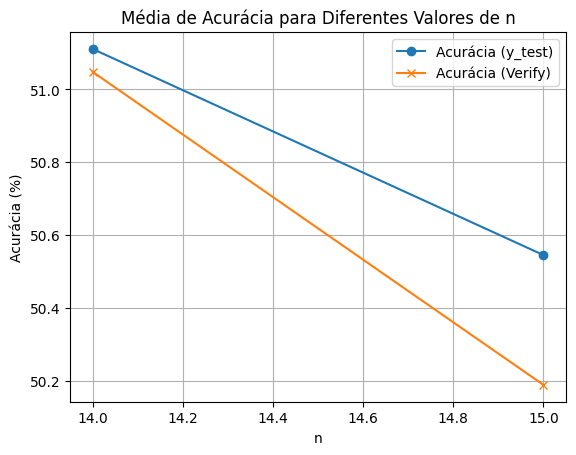

In [51]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

# Loop para cada n em n_list e realização de validação cruzada em série temporal
for n in n_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[[f'RSI_{n}',
                    f'k_percent_{t}',
                    f'r_percent_{t}',
                    'Price_Rate_Of_Change',
                    'MACD',
                    'MACD_EMA',
                    f'On Balance Volume']]
    y = price_data[f'Prediction']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()


#### Caso apareça erro float 32

n: 2
Fold 1:
 - Correct Prediction (y_test): 41.99%
 - Correct Prediction (Verify): 41.77%
Fold 2:
 - Correct Prediction (y_test): 46.37%
 - Correct Prediction (Verify): 47.12%
Fold 3:
 - Correct Prediction (y_test): 53.85%
 - Correct Prediction (Verify): 53.31%
Fold 4:
 - Correct Prediction (y_test): 49.04%
 - Correct Prediction (Verify): 49.68%
Fold 5:
 - Correct Prediction (y_test): 49.15%
 - Correct Prediction (Verify): 47.76%
Média de acurácia (y_test) para n 2: 48.08%
Média de acurácia (Verify) para n 2: 47.93%
---
n: 4
Fold 1:
 - Correct Prediction (y_test): 48.16%
 - Correct Prediction (Verify): 47.85%
Fold 2:
 - Correct Prediction (y_test): 47.74%
 - Correct Prediction (Verify): 49.00%
Fold 3:
 - Correct Prediction (y_test): 50.58%
 - Correct Prediction (Verify): 50.68%
Fold 4:
 - Correct Prediction (y_test): 51.52%
 - Correct Prediction (Verify): 51.63%
Fold 5:
 - Correct Prediction (y_test): 46.07%
 - Correct Prediction (Verify): 45.65%
Média de acurácia (y_test) para n 4: 4

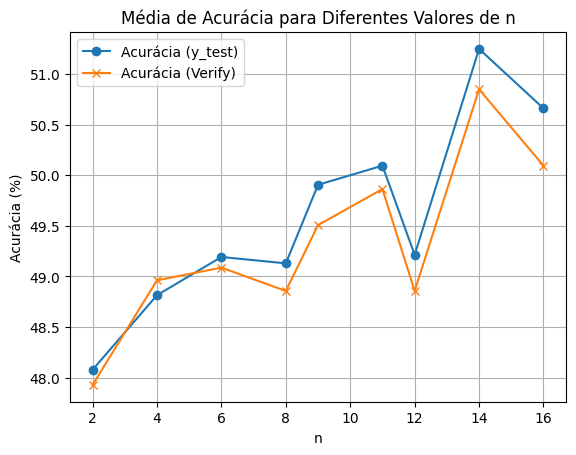

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por n
mean_accuracy_by_n = []

for n in n_list:
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}_n{n}',
                    f'r_percent_{alpha:.2f}_n{n}',
                    f'Price_Rate_Of_Change_{alpha:.2f}_n{n}',
                    f'MACD_{alpha:.2f}_n{n}',
                    f'MACD_EMA_{alpha:.2f}_n{n}',
                    f'OBV_{alpha:.2f}_n{n}']]
    y = price_data[f'Prediction_{alpha:.2f}_n{n}']
    verify = price_data['Verify']

    # Concatenar e tratar NaN
    data = pd.concat([X, y, verify], axis=1).replace([np.inf, -np.inf], np.nan).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]


    # Converter para float32
    X = X.astype(np.float32)

    # Configurar TimeSeriesSplit e o resto do código
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse n
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []



    print(f'n: {n}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por n
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_n.append((n, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para n {n}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para n {n}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for n, acc_ytest, acc_verify in mean_accuracy_by_n:
    print(f'n: {n} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por n
import matplotlib.pyplot as plt

n_values, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_n)

plt.plot(n_values, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(n_values, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Valores de n")
plt.xlabel('n')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()